In [ ]:
# Inference of CICIDS train + Synthetic data generated by GReaT with Random Forest 

/tmp/ipykernel_1443353/1550817734.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/tmp/ipykernel_1443353/1550817734.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1443353/1550817734.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/tmp/ipykernel_1443353/1550817734.py:35: SettingWithCopyWarning: 
A value is t

Training time:  494.94872522354126
Inference time per sample:  1.0781058928813368e-05
Accuracy =  0.9420182194940767
Precision =  0.6501300609754105
Recall =  0.9350589060799471
F1 =  0.6888605966066287


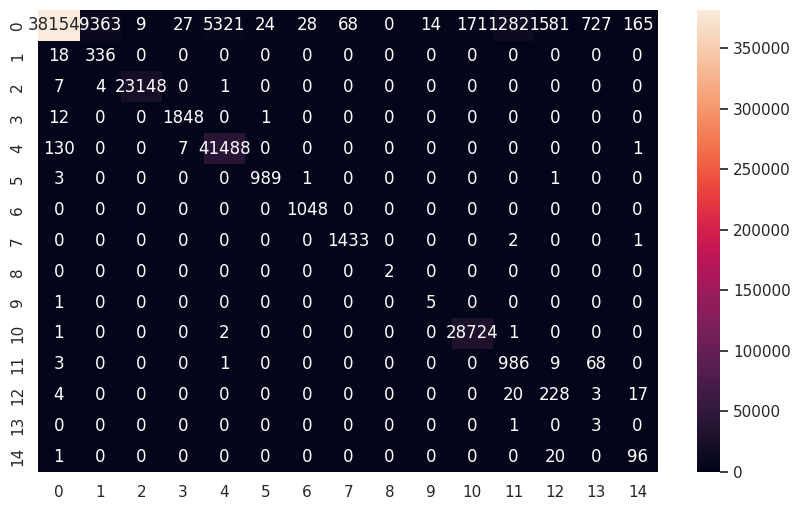

Classification Report:
                           precision    recall  f1-score   support

                   BENIGN     0.9995    0.9286    0.9628    410865
                      Bot     0.0346    0.9492    0.0668       354
                     DDoS     0.9996    0.9995    0.9995     23160
            DoS_GoldenEye     0.9819    0.9930    0.9874      1861
                 DoS_Hulk     0.8862    0.9967    0.9382     41626
         DoS_Slowhttptest     0.9753    0.9950    0.9851       994
            DoS_slowloris     0.9731    1.0000    0.9864      1048
              FTP-Patator     0.9547    0.9979    0.9758      1436
               Heartbleed     1.0000    1.0000    1.0000         2
             Infiltration     0.2632    0.8333    0.4000         6
                 PortScan     0.9941    0.9999    0.9970     28728
              SSH-Patator     0.0713    0.9241    0.1324      1067
  Web_Attack__Brute_Force     0.2718    0.8382    0.4104       272
Web_Attack__Sql_Injection     0.0037  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
from sklearn import metrics


# Preprocess the dataset
def change(df):
    if "Label" not in df.columns:
        raise ValueError("The DataFrame does not contain a 'Label' column.")
    
    # Standardize column names
    column_names = [name.strip().replace(" ", "_") for name in df.columns]
    _dict = {k: v for k, v in zip(df.columns, column_names)}
    df.rename(columns=_dict, inplace=True)
    
    # Standardize label names
    labels = df["Label"].unique().tolist()
    new_labels = [''.join(filter(lambda x: ord(x) < 128, l.strip().replace(" ", "_"))) for l in labels]
    _dict = {k: v for k, v in zip(labels, new_labels)}
    df["Label"] = df["Label"].replace(to_replace=_dict)
    return df

def clean_dataset(df):
    # Ensure valid input
    assert isinstance(df, pd.DataFrame), "Input must be a pandas DataFrame"
    
    # Drop rows with NaN or infinite values
    df.dropna(inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    # Clip extreme values
    df = df.clip(lower=-1e6, upper=1e6)
    
    return df.astype(np.float64)

# Load data
train_df = pd.read_csv('./Data/CICIDS_data/CICIDS_clean_train.csv')
train_df.columns = train_df.columns.str.strip()

concat_small_train = pd.read_csv( "/home/sharedrive/Nasik/Intrusion_Detection_Extension/Data/CICIDS_data/Great_Synthetic_1000_R3.csv")




test_df1 = pd.read_csv('./Data/ITU/test.csv') #ITU

#test_df1 = pd.read_csv('./Data/CICIDS_data/CICIDS_clean_test.csv')  #CICIDS
test_df1.columns = test_df1.columns.str.strip()
#concat_small_test = pd.read_csv('./Data/CICIDS_Small_Classes_Cleaned.csv')



# Apply preprocessing
train_df = change(train_df)
concat_small_train = change(concat_small_train)


test_df1 = change(test_df1)
#concat_small_test = change(concat_small_test)

# Concatenate training and test data
final_train_df = pd.concat([train_df, concat_small_train], ignore_index=True)
final_train_df = train_df


#final_test_df = pd.concat([test_df1, concat_small_test], ignore_index=True)
final_test_df = test_df1

rf_features = ['Flow_Duration', 'Total_Length_of_Bwd_Packets', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Mean', 'Flow_Bytes/s', 'Flow_Packets/s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max', 
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Fwd_Packets/s', 'Bwd_Packets/s', 'Max_Packet_Length',
       'Packet_Length_Mean', 'Average_Packet_Size', 'Avg_Bwd_Segment_Size',
       'Subflow_Bwd_Bytes', 'min_seg_size_forward']


X_train = final_train_df[rf_features]
y_train = final_train_df["Label"]

X_test = final_test_df[rf_features]
y_test = final_test_df["Label"]

# Clean datasets
X_train = clean_dataset(X_train)
X_test = clean_dataset(X_test)

# Align labels with cleaned data
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

# Label preparation for RandomForest
le = LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)
pickle.dump(le, open("./models/all_class_label_encoder.pkl", "wb"))

# Train RandomForest
RF_model = RandomForestClassifier(class_weight="balanced", random_state=1002, oob_score=True)

st = time.time()
RF_model.fit(X_train, y_train_encoded)
print("Training time: ", time.time() - st)

# Evaluate the model
st = time.time()
prediction_RF = RF_model.predict(X_test)
print("Inference time per sample: ", (time.time() - st) / len(X_test))

# Decode predictions
prediction_RF = le.inverse_transform(prediction_RF)

# Metrics
print("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))
print("Precision = ", metrics.precision_score(y_test, prediction_RF, average='macro'))
print("Recall = ", metrics.recall_score(y_test, prediction_RF, average='macro'))
print("F1 = ", metrics.f1_score(y_test, prediction_RF, average='macro'))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_RF)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, prediction_RF, digits=4))


In [ ]:
## RF iterative inference with 100 samples per class on each iteration from the synthetically generated data from KB

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import time

# Load data
train_df = pd.read_csv('./Data/CICIDS_data/CICIDS_clean_train.csv')
train_df.columns = train_df.columns.str.strip()

synthetic_df = pd.read_csv("/home/sharedrive/Nasik/Intrusion_Detection_Extension/Data/CICIDS_data/Great_Synthetic_1000_R1_N.csv")

#test_df1 = pd.read_csv('./Data/ITU/test.csv')  # ITU

test_df1 = pd.read_csv('./Data/CICIDS_data/CICIDS_clean_test.csv')  # ITU
test_df1.columns = test_df1.columns.str.strip()

# Function to clean column names and labels
def change(df):
    if "Label" not in df.columns:
        raise ValueError("The DataFrame does not contain a 'Label' column.")
    
    column_names = [name.strip().replace(" ", "_") for name in df.columns]
    df.rename(columns=dict(zip(df.columns, column_names)), inplace=True)

    labels = df["Label"].unique().tolist()
    new_labels = [''.join(filter(lambda x: ord(x) < 128, l.strip().replace(" ", "_"))) for l in labels]
    df["Label"] = df["Label"].replace(dict(zip(labels, new_labels)))
    return df

# Clean datasets
train_df = change(train_df)
synthetic_df = change(synthetic_df)
test_df1 = change(test_df1)

# Define feature set
rf_features = ['Flow_Duration', 'Total_Length_of_Bwd_Packets', 'Bwd_Packet_Length_Max',
       'Bwd_Packet_Length_Mean', 'Flow_Bytes/s', 'Flow_Packets/s',
       'Flow_IAT_Mean', 'Flow_IAT_Std', 'Flow_IAT_Max',
       'Fwd_IAT_Total', 'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max',
       'Fwd_IAT_Min', 'Fwd_Packets/s', 'Bwd_Packets/s', 'Max_Packet_Length',
       'Packet_Length_Mean', 'Average_Packet_Size', 'Avg_Bwd_Segment_Size',
       'Subflow_Bwd_Bytes', 'min_seg_size_forward']

# Function to check for infinite or large values
def check_and_fix_data(df, features):
    # Check for infinite values
    if np.isinf(df[features]).any().any():
        print("Warning: Infinite values found in the dataset. Replacing with large finite values.")
        df[features] = df[features].replace([np.inf, -np.inf], np.finfo(np.float32).max)
    
    # Check for values too large for float32
    max_float32 = np.finfo(np.float32).max
    if (df[features].abs() > max_float32).any().any():
        print("Warning: Values too large for float32 found in the dataset. Scaling down.")
        df[features] = df[features].clip(lower=-max_float32, upper=max_float32)
    
    return df

# Fix data in train, synthetic, and test datasets
train_df = check_and_fix_data(train_df, rf_features)
synthetic_df = check_and_fix_data(synthetic_df, rf_features)
test_df1 = check_and_fix_data(test_df1, rf_features)

# Prepare test data
X_test = test_df1[rf_features]
y_test = test_df1["Label"]

# Label Encoding
le = LabelEncoder()
le.fit(train_df["Label"])
train_df["Label"] = le.transform(train_df["Label"])
synthetic_df["Label"] = le.transform(synthetic_df["Label"])
y_test_encoded = le.transform(y_test)

# Save the label encoder
pickle.dump(le, open("./models/all_class_label_encoder.pkl", "wb"))

# Function to sample synthetic data per class
def get_synthetic_sample(synthetic_df, sample_size_per_class):
    # Sample `sample_size_per_class` rows for each class
    sampled_synthetic_df = synthetic_df.groupby("Label", group_keys=False).apply(
        lambda x: x.sample(n=sample_size_per_class, random_state=42)
    )
    return sampled_synthetic_df

# Initialize an empty DataFrame to accumulate synthetic data
accumulated_synthetic_df = pd.DataFrame()

# Initialize Random Forest model
RF_model = RandomForestClassifier(class_weight="balanced", random_state=1002, oob_score=True, n_jobs=-1)

# Iterative training with increasing synthetic data
for i in range(1, 11):  # 100, 200, ..., 1000
    synthetic_sample_size_per_class = 100  # Add 100 samples per class in each iteration
    
    # Sample synthetic data for this iteration
    new_synthetic_df = get_synthetic_sample(synthetic_df, sample_size_per_class=synthetic_sample_size_per_class)
    
    # Accumulate synthetic data
    accumulated_synthetic_df = pd.concat([accumulated_synthetic_df, new_synthetic_df], ignore_index=True)
    
    # Combine with original training data
    combined_train_df = pd.concat([train_df, accumulated_synthetic_df], ignore_index=True)
    
    # Extract features and labels
    X_train = combined_train_df[rf_features]
    y_train = combined_train_df["Label"]

    # Train Random Forest
    st = time.time()
    RF_model.fit(X_train, y_train)
    train_time = time.time() - st

    # Evaluate on test set
    st = time.time()
    prediction_RF = RF_model.predict(X_test)
    inference_time = (time.time() - st) / len(X_test)

    # Decode predictions
    prediction_RF = le.inverse_transform(prediction_RF)

    # Print classification report
    print(f"Iteration {i}: Total synthetic data per class = {i * 100}")
    print(f"Training time: {train_time:.4f} seconds")
    print(f"Inference time per sample: {inference_time:.6f} seconds")
    print(classification_report(y_test, prediction_RF, digits=4))
    print("-" * 80)

Iteration 1: Total synthetic data per class = 100
Training time: 77.4981 seconds
Inference time per sample: 0.000002 seconds
                           precision    recall  f1-score   support

                   BENIGN     0.9989    0.9285    0.9624    681396
                      Bot     0.0296    0.7990    0.0572       587
                     DDoS     0.9989    0.9985    0.9987     38408
            DoS_GoldenEye     0.9699    0.9796    0.9747      3088
                 DoS_Hulk     0.8838    0.9937    0.9355     69037
         DoS_Slowhttptest     0.9498    0.9855    0.9673      1650
            DoS_slowloris     0.9736    0.9948    0.9841      1739
              FTP-Patator     0.9654    0.9979    0.9814      2380
               Heartbleed     1.0000    0.6667    0.8000         3
             Infiltration     0.2258    0.6364    0.3333        11
                 PortScan     0.9935    0.9995    0.9965     47641
              SSH-Patator     0.0713    0.9282    0.1325      1769
  W